In [25]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, cross_val_score
import shap
from statsmodels.stats.proportion import proportions_ztest

In [5]:
df = pd.read_csv('hockey_sentiment.csv')

### plot distributions

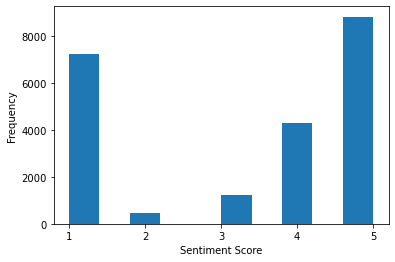

In [ ]:
# overall sentiment
plt.hist(df['sentiment'])
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')

plt.xticks(ticks=np.arange(df['sentiment'].min(), df['sentiment'].max()+1, 1))
plt.show()

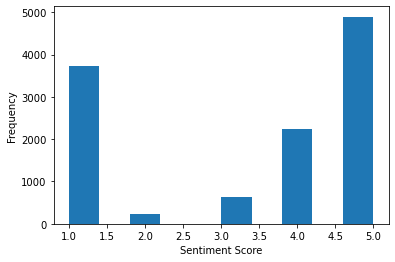

In [16]:
# winning sentiment
win_scores = df[df['team_won'] == 1]['sentiment']
plt.hist(win_scores)
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')

plt.show()

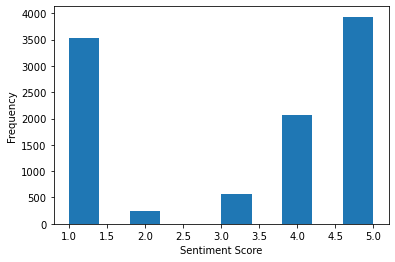

In [17]:
# losing sentiment
lose_scores = df[df['team_won'] == 0]['sentiment']
plt.hist(lose_scores)
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')

plt.show()

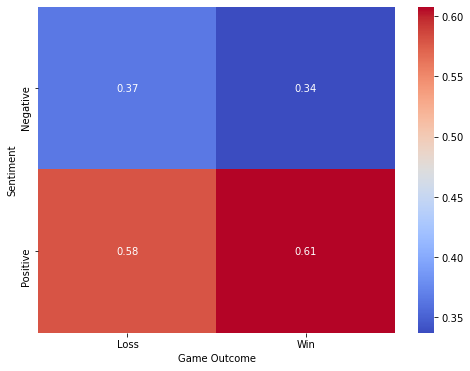

In [20]:
# Calculate proportions
win_pos_proportion = win_scores[win_scores > 3].count() / len(win_scores)
win_neg_proportion = win_scores[win_scores < 3].count() / len(win_scores)
lose_pos_proportion = lose_scores[lose_scores > 3].count() / len(lose_scores)
lose_neg_proportion = lose_scores[lose_scores < 3].count() / len(lose_scores)
# Data for heatmap
data = {
    'Game Outcome': ['Win', 'Win', 'Loss', 'Loss'],
    'Sentiment': ['Positive', 'Negative', 'Positive', 'Negative'],
    'Proportion': [win_pos_proportion, win_neg_proportion, lose_pos_proportion, lose_neg_proportion]
}


heatmap_df = pd.DataFrame(data)

# Pivot the data for heatmap
heatmap_data = heatmap_df.pivot(index='Sentiment', columns='Game Outcome', values='Proportion')

# Create the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, annot=True, cmap='coolwarm', cbar=True)


plt.show()


In [24]:
# Calculate overall positive and negative proportions
overall_pos_proportion = df[df['sentiment'] > 3].shape[0] / df.shape[0]
overall_neg_proportion = df[df['sentiment'] < 3].shape[0] / df.shape[0]

# Calculate overall positive and negative counts
overall_pos_count = df[df['sentiment'] > 3].shape[0]
overall_neg_count = df[df['sentiment'] < 3].shape[0]

# Create a table with the number of winning, losing, and overall posts with positive and negative scores and their proportions
table_data = {
    'Score Type': ['Positive', 'Negative', 'Positive', 'Negative', 'Positive', 'Negative'],
    'Count': [win_scores[win_scores > 3].count(), win_scores[win_scores < 3].count(), lose_scores[lose_scores > 3].count(), lose_scores[lose_scores < 3].count(), overall_pos_count, overall_neg_count],
    'Proportion': [win_pos_proportion, win_neg_proportion, lose_pos_proportion, lose_neg_proportion, overall_pos_proportion, overall_neg_proportion],
    'Category': ['Win', 'Win', 'Loss', 'Loss', 'Overall', 'Overall']
}

table_df = pd.DataFrame(table_data)
print(table_df)


  Score Type  Count  Proportion Category
0   Positive   7138    0.607851      Win
1   Negative   3961    0.337307      Win
2   Positive   6004    0.580321     Loss
3   Negative   3779    0.365262     Loss
4   Positive  13142    0.594957  Overall
5   Negative   7740    0.350401  Overall


### Analysis

In [26]:
# Winning posts with positive sentiment
win_pos_count = win_scores[win_scores > 3].count()
win_pos_nobs = len(win_scores)
stat_win_pos, pval_win_pos = proportions_ztest(win_pos_count, win_pos_nobs, value=0.595)
print(f"Winning posts with positive sentiment - Z-statistic: {stat_win_pos}, P-value: {pval_win_pos}")

# Losing posts with positive sentiment
lose_pos_count = lose_scores[lose_scores > 3].count()
lose_pos_nobs = len(lose_scores)
stat_lose_pos, pval_lose_pos = proportions_ztest(lose_pos_count, lose_pos_nobs, value=0.595)
print(f"Losing posts with positive sentiment - Z-statistic: {stat_lose_pos}, P-value: {pval_lose_pos}")

# Winning posts with negative sentiment
win_neg_count = win_scores[win_scores < 3].count()
win_neg_nobs = len(win_scores)
stat_win_neg, pval_win_neg = proportions_ztest(win_neg_count, win_neg_nobs, value=0.35)
print(f"Winning posts with negative sentiment - Z-statistic: {stat_win_neg}, P-value: {pval_win_neg}")

# Losing posts with negative sentiment
lose_neg_count = lose_scores[lose_scores < 3].count()
lose_neg_nobs = len(lose_scores)
stat_lose_neg, pval_lose_neg = proportions_ztest(lose_neg_count, lose_neg_nobs, value=0.35)
print(f"Losing posts with negative sentiment - Z-statistic: {stat_lose_neg}, P-value: {pval_lose_neg}")


Winning posts with positive sentiment - Z-statistic: 2.8524553130017916, P-value: 0.004338291165541003
Losing posts with positive sentiment - Z-statistic: -3.025470889831529, P-value: 0.0024824630003515923
Winning posts with negative sentiment - Z-statistic: -2.9091993132111686, P-value: 0.0036235576564618084
Losing posts with negative sentiment - Z-statistic: 3.2240102430792494, P-value: 0.001264088780043928


In [ ]:
# OLS on overall
X = df[["team_won", "closeGame",'blowout',"highScoring",'above500', 'daysSinceLastGame', 'won_previous', 'season_phase']]
y = df['sentiment']
# Add a constant (intercept)
X = sm.add_constant(X)

ols_model = sm.OLS(y, X)
ols_results = ols_model.fit()
print(ols_results.summary())



                            OLS Regression Results                            
Dep. Variable:              sentiment   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     10.32
Date:                Tue, 26 Nov 2024   Prob (F-statistic):           1.60e-14
Time:                        18:32:36   Log-Likelihood:                -43547.
No. Observations:               22089   AIC:                         8.711e+04
Df Residuals:                   22080   BIC:                         8.718e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 3.2404      0.04

In [ ]:
# XGBoost on overall
X = df[["team_won", "closeGame",'blowout',"highScoring",'above500', 'daysSinceLastGame', 'won_previous', 'season_phase']]
y = df['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [30]:
def performGridSearch(param_grid, model):
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5)
    grid_search.fit(X_train, y_train)
    return grid_search

In [31]:
xgb_model = XGBRegressor()
param_grid_xgb = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}
# Get the best model
grid_search_xgb1 = performGridSearch(param_grid_xgb, xgb_model)
best_model_xgb1 = grid_search_xgb1.best_estimator_

In [32]:
y_pred_xgbb = best_model_xgb1.predict(X_test)

In [33]:
mse_xgb1 = mean_squared_error(y_test, y_pred_xgbb)
print(f"Mean Squared Error (XGBoost): {mse_xgb1}")
r2_xgb1 = best_model_xgb1.score(X_train, y_train)
print(f"R squared (XGBoost): {r2_xgb1}")

Mean Squared Error (XGBoost): 3.021773253977119
R squared (XGBoost): 0.018430070540548904


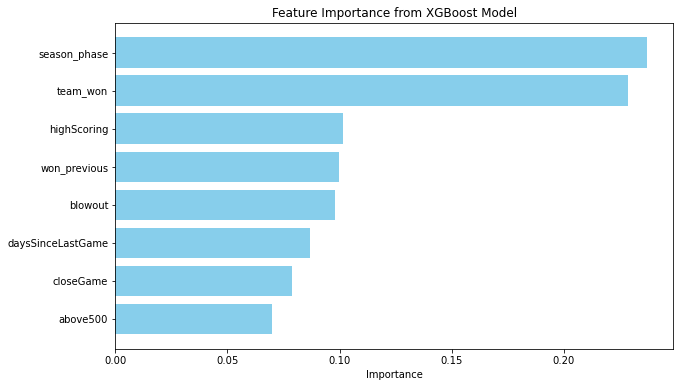

In [34]:
xgb_feature_importances = best_model_xgb1.feature_importances_
xgb_feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': xgb_feature_importances
}).sort_values(by='Importance', ascending=True)

plt.figure(figsize=(10, 6))
plt.barh(xgb_feature_importance_df['Feature'], xgb_feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importance from XGBoost Model')
plt.show()

In [35]:
%%time
# Explain predictions with SHAP
explainer = shap.Explainer(best_model_xgb1, X_train)
shap_values1 = explainer(X_test, check_additivity=False)

 94%|=================== | 4139/4418 [00:16<00:01]       

CPU times: user 18.2 s, sys: 1.36 s, total: 19.6 s
Wall time: 16.3 s


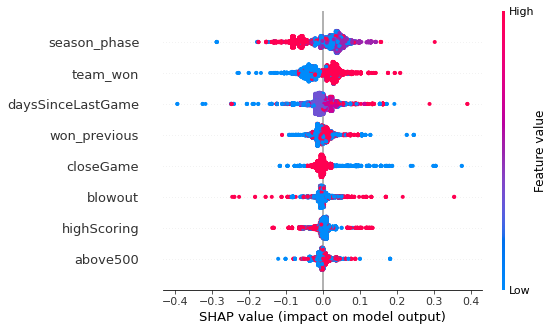

In [36]:
shap.summary_plot(shap_values1, X_test, )

In [38]:
# winning posts
df_win = df[df['team_won'] == 1]

In [39]:
X = df_win[["closeGame",'blowout',"highScoring",'above500', 'daysSinceLastGame', 'won_previous', 'season_phase']]
y = df_win['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [40]:
def performGridSearch(param_grid, model):
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5)
    grid_search.fit(X_train, y_train)
    return grid_search

In [41]:
xgb_model = XGBRegressor()
param_grid_xgb = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}
# Get the best model
grid_search_xgb1 = performGridSearch(param_grid_xgb, xgb_model)
best_model_xgb1 = grid_search_xgb1.best_estimator_

In [42]:
y_pred_xgbb = best_model_xgb1.predict(X_test)

In [43]:
mse_xgb1 = mean_squared_error(y_test, y_pred_xgbb)
print(f"Mean Squared Error (XGBoost): {mse_xgb1}")
r2_xgb1 = best_model_xgb1.score(X_train, y_train)
print(f"R squared (XGBoost): {r2_xgb1}")

Mean Squared Error (XGBoost): 2.9594357150003834
R squared (XGBoost): 0.01957490541143836


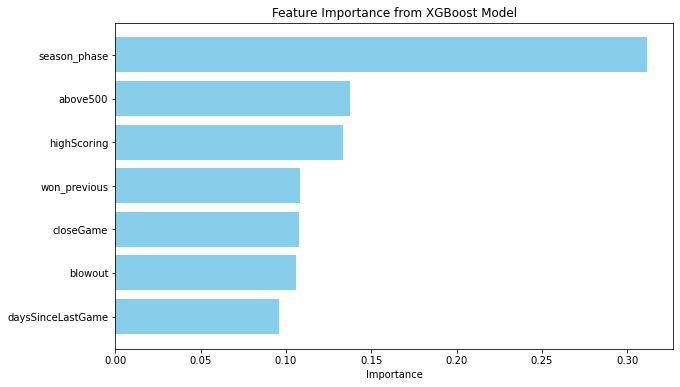

In [44]:
xgb_feature_importances = best_model_xgb1.feature_importances_
xgb_feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': xgb_feature_importances
}).sort_values(by='Importance', ascending=True)

plt.figure(figsize=(10, 6))
plt.barh(xgb_feature_importance_df['Feature'], xgb_feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importance from XGBoost Model')
plt.show()

In [45]:
%%time
# Explain predictions with SHAP
explainer = shap.Explainer(best_model_xgb1, X_train)
shap_values1 = explainer(X_test, check_additivity=False)

CPU times: user 8.53 s, sys: 1.22 s, total: 9.75 s
Wall time: 7.09 s


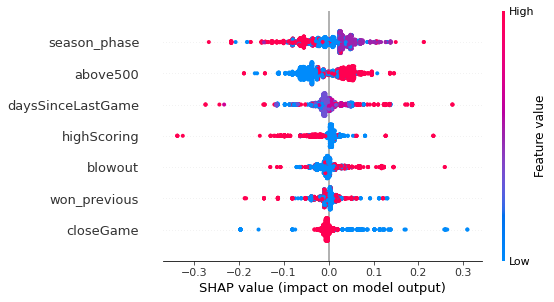

In [46]:
shap.summary_plot(shap_values1, X_test, )

In [47]:
# losing posts
df_lose = df[df['team_won'] == 0]

In [48]:
X = df_lose[["closeGame",'blowout',"highScoring",'above500', 'daysSinceLastGame', 'won_previous', 'season_phase']]
y = df_lose['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [49]:
def performGridSearch(param_grid, model):
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5)
    grid_search.fit(X_train, y_train)
    return grid_search

In [50]:
xgb_model = XGBRegressor()
param_grid_xgb = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}
# Get the best model
grid_search_xgb1 = performGridSearch(param_grid_xgb, xgb_model)
best_model_xgb1 = grid_search_xgb1.best_estimator_

In [51]:
y_pred_xgbb = best_model_xgb1.predict(X_test)

In [52]:
mse_xgb1 = mean_squared_error(y_test, y_pred_xgbb)
print(f"Mean Squared Error (XGBoost): {mse_xgb1}")
r2_xgb1 = best_model_xgb1.score(X_train, y_train)
print(f"R squared (XGBoost): {r2_xgb1}")

Mean Squared Error (XGBoost): 2.9941907537545758
R squared (XGBoost): 0.013697065343004744


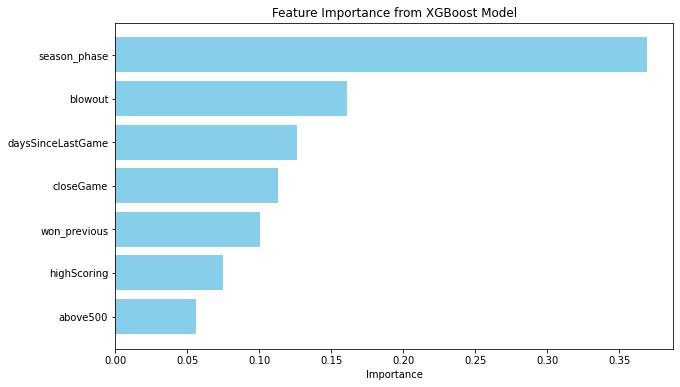

In [53]:
xgb_feature_importances = best_model_xgb1.feature_importances_
xgb_feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': xgb_feature_importances
}).sort_values(by='Importance', ascending=True)

plt.figure(figsize=(10, 6))
plt.barh(xgb_feature_importance_df['Feature'], xgb_feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importance from XGBoost Model')
plt.show()

In [54]:
%%time
# Explain predictions with SHAP
explainer = shap.Explainer(best_model_xgb1, X_train)
shap_values1 = explainer(X_test, check_additivity=False)

CPU times: user 4.76 s, sys: 849 ms, total: 5.61 s
Wall time: 3.38 s


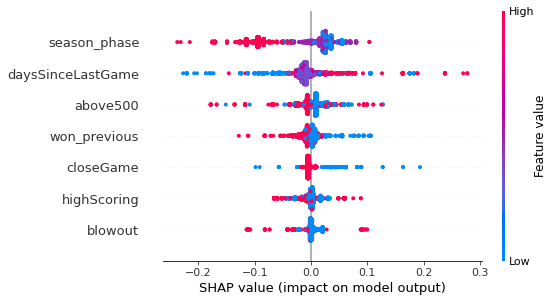

In [55]:
shap.summary_plot(shap_values1, X_test, )